In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
from copy import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd

In [2]:
def norm(x):
    sum_sq = x.dot(x.T)
    norm = np.sqrt(sum_sq)
    return norm

In [5]:
wiki = pd.read_csv('people_wiki.csv')

In [8]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [9]:
corpus = load_sparse_csr('people_wiki_tf_idf.npz')

In [10]:
%ls

0_nearest-neighbors-features-and-metrics_blank.ipynb
Choosing features and metrics for nearest neighbor search.ipynb
Implementing Locality Sensitive Hashing from scratch.ipynb
_167fc84b78dc145609e919983b475aaa_people_wiki.csv (1).zip
_167fc84b78dc145609e919983b475aaa_people_wiki.csv.zip
_395a4cfb2299d1655f1ef6bf6cc4f71b_people_wiki_tf_idf.npz (1).zip
_395a4cfb2299d1655f1ef6bf6cc4f71b_people_wiki_tf_idf.npz.zip
_395a4cfb2299d1655f1ef6bf6cc4f71b_people_wiki_word_count.npz.zip
_96eadbec4d43a0b0870dde27d0652fb2_people_wiki_map_index_to_word.gl.zip
_96eadbec4d43a0b0870dde27d0652fb2_people_wiki_map_index_to_word.json (1).zip
_96eadbec4d43a0b0870dde27d0652fb2_people_wiki_map_index_to_word.json.zip
_a20552cf806c54b71b3b87cb593b9968_1_nearest-neighbors-lsh-implementation_blank.ipynb.zip
people_wiki.csv
people_wiki_map_index_to_word.gl/
people_wiki_map_index_to_word.json
people_wiki_tf_idf.npz*
people_wiki_word_count.npz*


In [11]:
map_index_to_word_tmp = pd.read_json('people_wiki_map_index_to_word.json', typ='series')

In [12]:
map_index_to_word = dict(zip(map_index_to_word_tmp.values, map_index_to_word_tmp.index))

## Train an LSH model

In [14]:
np.random.seed(0)

In [18]:
print (np.random.randn(3,5))

[[-0.67246045 -0.35955316 -0.81314628 -1.7262826   0.17742614]
 [-0.40178094 -1.63019835  0.46278226 -0.90729836  0.0519454 ]
 [ 0.72909056  0.12898291  1.13940068 -1.23482582  0.40234164]]


In [19]:
# Generate 16 random vectors of dimension 547979

In [35]:
random_vectors = np.random.randn(corpus.shape[1], 16)

In [38]:
corpus[0, :].dot(random_vectors[:,0])

array([-10.75831177])

In [ ]:
random_vectors

In [49]:
corpus[1, :].dot(random_vectors[:, 1])

array([-79.48208695])

In [45]:
corpus.dot(random_vectors)

array([[-10.75831177, -36.2195752 ,  10.11565021, ...,  70.11108943,
         80.79954919,  19.77278735],
       [-65.42852931, -79.48208695,  66.82961146, ..., 136.53574183,
         -6.21121245,  97.84375582],
       [ 70.32794796, -21.45613804,  19.58457063, ..., -29.1986301 ,
         20.77323402,  30.5596533 ],
       ...,
       [ -2.86444408,  37.3277731 , -68.54134263, ..., 196.53262969,
         34.63359376, 130.12175948],
       [116.26335162, -53.30066576,  57.75022709, ...,  99.53362599,
         53.47174929,  51.23579779],
       [ 24.54689445,  49.80280825,  75.43859601, ...,  48.09370423,
        168.19028917, 102.3060707 ]])

In [41]:
corpus.dot(random_vectors) >= 0

array([[False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True, False,  True],
       [ True, False,  True, ..., False,  True,  True],
       ...,
       [False,  True, False, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [55]:
powers_of_two = (1 << np.arange(15, -1, -1))

In [59]:
index_bits = (corpus.dot(random_vectors) >= 0).dot(powers_of_two)

In [60]:
index_bits

array([10447, 12709, 42627, ..., 17607, 48231, 60895])

In [120]:
def train_lsh(data, num_vector=16, seed=None):
    dim = data.shape[1]
    
    if seed is not None:
        print ("Set random seed to %s" % seed)
        np.random.seed(seed)
    random_vectors = np.random.randn(dim, num_vector)
    powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors)) >= 0
    
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with
    # bin index equal to i
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            table[bin_index] = []
        
        table[bin_index] += [data_index]
    
    model = {
        'data': data,
        'bin_index_bits': bin_index_bits,
        'bin_indices': bin_indices,
        'table': table,
        'random_vectors': random_vectors,
        'num_vector': num_vector
    }
        
    return model

In [121]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if  0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print ('Passed!')
else:
    print ('Check your code.')

Set random seed to 143
Passed!


### Inspect bins

## Quiz Question. What is the document id of Barack Obama's article?



In [136]:
obama_id = wiki[wiki['name'] == 'Barack Obama'].index.values[0]
obama_id

35817

## Quiz Question. Which bin contains Barack Obama's article? Enter its integer index.



In [138]:
model['bin_indices'][obama_id]

50194

In [139]:
table[50194]

[21426, 35817, 39426, 50261, 53937]

## Quiz Question. Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?



In [140]:
biden_id = wiki[wiki['name'] == 'Joe Biden'].index.values[0]

In [142]:
biden_id

24478

In [146]:
(model['bin_index_bits'][biden_id] == model['bin_index_bits'][obama_id]).sum()

14

### How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden? Let's look at which documents are in the same bin as the Barack Obama article.



In [147]:
print (model['table'][model['bin_indices'][obama_id]])

[21426, 35817, 39426, 50261, 53937]


In [149]:
doc_ids = list(model['table'][model['bin_indices'][obama_id]])
doc_ids.remove(obama_id) # display documents other than Obama

In [171]:
wiki.loc[doc_ids, :]

,URI,name,text
21426,<http://dbpedia.org/resource/Mark_Boulware>,Mark Boulware,mark boulware born 1948 is an american diploma...
39426,<http://dbpedia.org/resource/John_Wells_(polit...,John Wells (politician),sir john julius wells born 30 march 1925 is a ...
50261,<http://dbpedia.org/resource/Francis_Longstaff>,Francis Longstaff,francis a longstaff born august 3 1956 is an a...
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv...,Madurai T. Srinivasan,maduraitsrinivasan is a wellknown figure in th...


In [172]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy / (norm(x) * norm(y))
    return 1 - dist[0, 0]

In [173]:
obama_tf_idf = corpus[obama_id, :]
biden_tf_idf = corpus[biden_id, :]

In [178]:
print ('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden', cosine_distance(obama_tf_idf, biden_tf_idf)))

Barack Obama - Joe Biden               : 0.703139


In [182]:
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id, :]
    print ('Barack Obama - {0:24s}: {1:f}'
           .format(wiki.loc[doc_id, 'name'], cosine_distance(obama_tf_idf,doc_tf_idf)))

Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


In [179]:
from itertools import combinations

In [183]:
bin(13)

'0b1101'

In [ ]:
combinations

In [181]:
for diff in combinations(range(16), 3):
    print (diff)

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [187]:
def search_nearby_bins(query_bin_bits, table, search_radius=2,
                       initial_candidates=set()):
    
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)
    
    # Allow the user to provide an initial set of candidates
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not alternate_bits[i]
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new
        # bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])
    
    return candidate_set

In [188]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print ('Passed test')
else:
    print ('Check your code')
print ('List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261')

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [189]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)

if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print ('Passed test')
else:
    print ('Check your code')

Passed test


In [210]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius,
                                           initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    candidate_list = list(candidate_set)
    nearest_neighbors = pd.DataFrame({'id': candidate_list})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return (nearest_neighbors.sort_values('distance', ascending=True).iloc[0:k,:], len(candidate_list))

In [212]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)

In [219]:
result.merge(wiki, how='inner', left_on='id', right_index=True)[['id', 'distance', 'name']]

,id,distance,name
369,35817,0.000000,Barack Obama
704,24478,0.703139,Joe Biden
267,56008,0.856848,Nathan Cullen
132,37199,0.874669,Barry Sullivan (lawyer)
515,40353,0.890034,Neil MacBride
390,9267,0.898377,Vikramaditya Khanna
228,55909,0.899340,Herman Cain
359,9165,0.900921,Raymond F. Clevenger
229,57958,0.903003,Michael J. Malbin
269,49872,0.909533,Lowell Barron


## Experimenting with your LSH implementation


In [224]:
import time

In [227]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print ('Radius:', max_search_radius)
    # Display 10 nearest neighbors, along with document ID and name
    # print (result.join(wiki[['id', 'name']], on='id').sort('distance'))
    print (result.merge(wiki, how='inner', left_on='id', right_index=True)[['id', 'distance', 'name']])
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
      id  distance                     name
1  35817  0.000000             Barack Obama
3  21426  0.950867            Mark Boulware
0  39426  0.975966  John Wells (politician)
4  50261  0.978256        Francis Longstaff
2  53937  0.993092    Madurai T. Srinivasan
Radius: 1
       id  distance                                   name
16  35817  0.000000                           Barack Obama
13  41631  0.947459                            Binayak Sen
20  21426  0.950867                          Mark Boulware
9   33243  0.951766                        Janice Lachance
3   33996  0.960859                            Rufus Black
10  28444  0.961081                       John Paul Phelan
24  20347  0.974130                        Gianni De Fraja
0   39426  0.975966                John Wells (politician)
23  34547  0.978215  Nathan Murphy (Australian politician)
7   50261  0.978256                      Francis Longstaff
Radius: 2
        id  distance                 name
151  35817  0.0

Radius: 16
          id  distance                     name
35817  35817  0.000000             Barack Obama
24478  24478  0.703139                Joe Biden
38376  38376  0.742982           Samantha Power
57108  57108  0.758358   Hillary Rodham Clinton
38714  38714  0.770561  Eric Stern (politician)
46140  46140  0.784678             Robert Gibbs
6796    6796  0.788039              Eric Holder
44681  44681  0.790926   Jesse Lee (politician)
18827  18827  0.798323             Henry Waxman
2412    2412  0.799466          Joe the Plumber


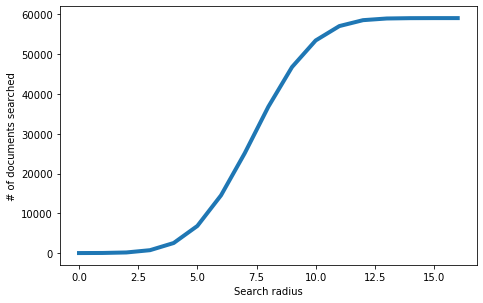

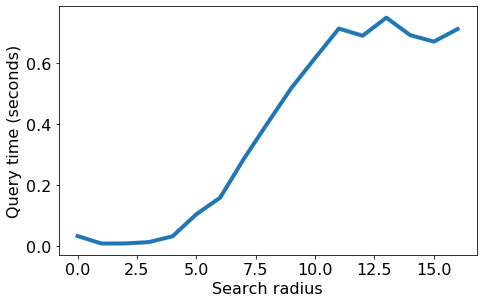

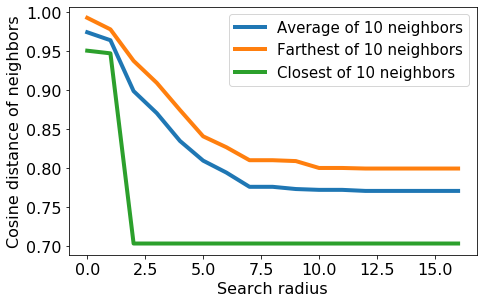

In [228]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Quiz Question. What was the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden?



In [229]:
2

2

## Quiz Question. Suppose our goal was to produce 10 approximate nearest neighbors whose average distance from the query document is within 0.01 of the average for the true 10 nearest neighbors. For Barack Obama, the true 10 nearest neighbors are on average about 0.77. What was the smallest search radius for Barack Obama that produced an average distance of 0.78 or better?



In [234]:
average_distance_from_query_history

[0.9745452682750878,
 0.9642887060258674,
 0.8989583845830388,
 0.8706516030485054,
 0.8349346493308571,
 0.8096145239653255,
 0.7943131453905069,
 0.7759826058523335,
 0.7759826058523335,
 0.77313498754465,
 0.7720700524117311,
 0.7720700524117311,
 0.7707191289494767,
 0.7707191289494767,
 0.7707191289494767,
 0.7707191289494767,
 0.7707191289494767]

In [233]:
(np.array(average_distance_from_query_history) <= 0.78).argmax()

7

## Quality metrics for neighbors


In [237]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values('distance', ascending=True).iloc[0:k, :]

In [238]:
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in range(1, max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


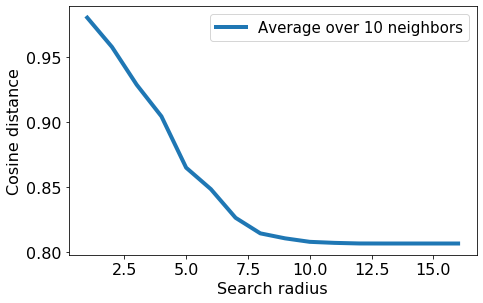

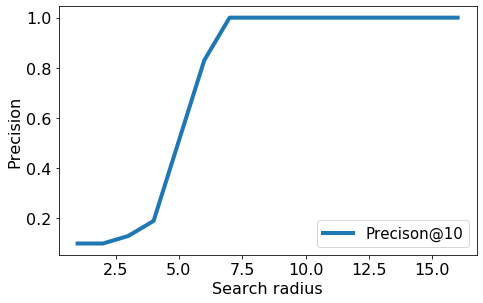

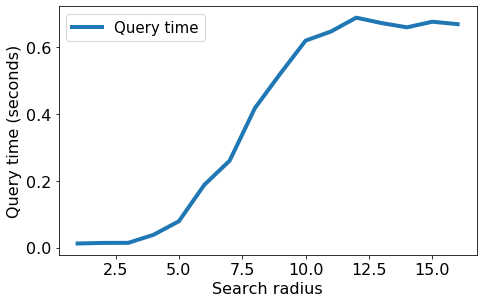

In [239]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Effect of number of random vectors

In [241]:
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
Set random seed to 143
num_vector = 6
Set random seed to 143
num_vector = 7
Set random seed to 143
num_vector = 8
Set random seed to 143
num_vector = 9
Set random seed to 143
num_vector = 10
Set random seed to 143
num_vector = 11
Set random seed to 143
num_vector = 12
Set random seed to 143
num_vector = 13
Set random seed to 143
num_vector = 14
Set random seed to 143
num_vector = 15
Set random seed to 143
num_vector = 16
Set random seed to 143
num_vector = 17
Set random seed to 143
num_vector = 18
Set random seed to 143
num_vector = 19
Set random seed to 143


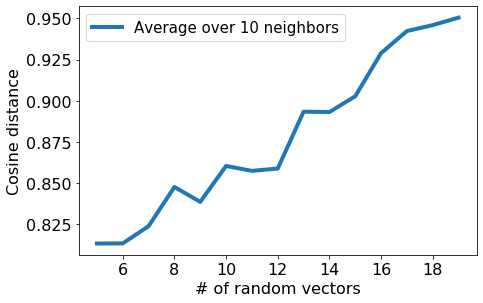

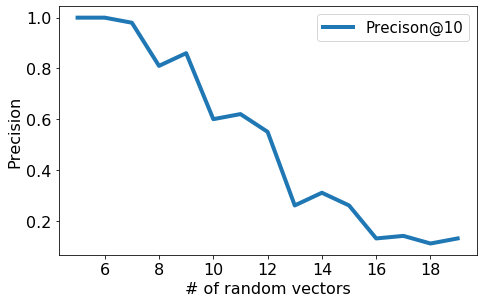

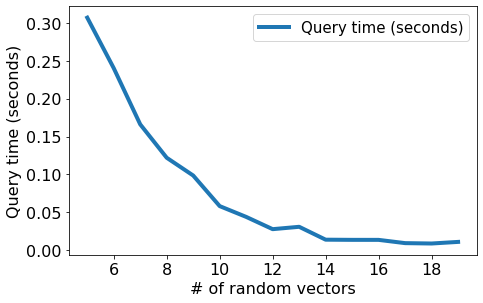

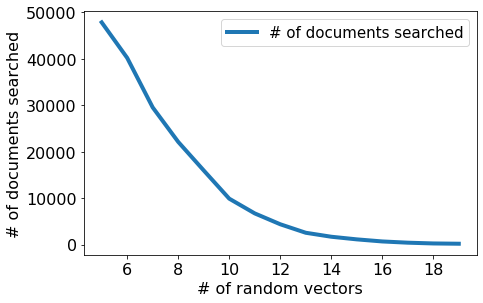

In [243]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()